# NBA Point Spread Regressor Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_point_spead_reg as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
import dataframe_image as dfi

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

Autosaving every 60 seconds


### Utils functions

In [3]:
def filter_from(items, cond):
    return list(filter(cond, items)) 

In [4]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [5]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [6]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [7]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [8]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [9]:
def plot_results(experiment_name, results, figsize=(10,6)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    #     a = sns.pointplot(data=results_df,
    #               kind="point", x="season_test", y="rmse", hue="model"
    #               )
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="mae", hue="model", style="model",
        markers=True, dashes=False
    )
    a.set_title(
        f"{experiment_name}-mae")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [10]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [11]:
reg_metrics = ['mae', 'mse', 'rmse']

def print_prettier_exp_results(exp_name, metric='mae', filter_val=None):
    second_metric = 'rmse' if metric == 'mae' else 'mae'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model == filter_val)
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=True)

## Load Dataset

In [12]:
season_games = sg.load_season_games_dataset()

## Dataset


In [13]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

In [14]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [15]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)
df.drop(df[df.G_PLAYED < 20].index, inplace = True)
print(df.shape)
utils.serialize_object('df', df)

(9599, 405)
0
(9461, 405)
(8372, 405)


In [16]:
pd.set_option('display.max_rows', 600)
df_styled = df[model_config.X_COLS_NO_HIGH_CORR].head(5)
to_image = df_styled.T
dfi.export(to_image, 'preliminar_first_5_games.png', max_rows=-1)

df_styled = df[model_config.X_COLS_NO_HIGH_CORR].tail(5)
to_image = df_styled.T
dfi.export(to_image, 'preliminar_last_5_games.png', max_rows=-1)

## Experiments

### Setup

In [16]:
exp_prefix = "reg_"
## exp_group_name = "reg_experiments"
exp_group_name = "reg_experiments"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_POINT_SPREAD"
exp_X_columns = model_config.X_COLS_NO_HIGH_CORR
exp_y_columns = model_config.Y_REG_COL

models = utils_exp.get_reg_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Experiment using 1 season

In [17]:
experiment_name = f"{exp_prefix}1_season"

In [18]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_1_season
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
3,reg_1_season,RF,9.852666,0.277389,12.545130,0.356161
1,reg_1_season,KNN,9.923061,0.217321,12.618358,0.283024
2,reg_1_season,SVM,10.088597,0.214758,12.838252,0.306322
0,reg_1_season,LR,10.250696,0.286978,13.025696,0.400877
4,reg_1_season,LGB,10.350949,0.261646,13.170608,0.328641
5,reg_1_season,XGB,10.705118,0.311235,13.608599,0.434667


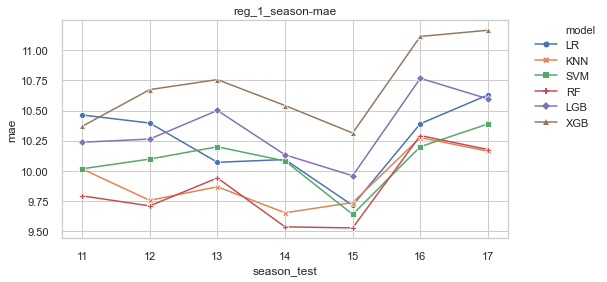

In [19]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [20]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1213,11,972
1,11,972,12,1209
2,12,1209,13,1213
3,13,1213,14,1213
4,14,1213,15,1213
5,15,1213,16,1214
6,16,1214,17,1214


### Experiment using StandardScaler

In [21]:
# experiment_name = f"{exp_prefix}scaled_data"

In [22]:
# del_result_by(experiment_name)

# num_pipeline = Pipeline([
#     ('std_scaler', StandardScaler())
# ])
# preprocessor = ColumnTransformer([
#         ('numerical', num_pipeline, exp_X_columns)
#     ], remainder='passthrough')
# #transformed_data = preprocessor.fit_transform(df)

# folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

In [23]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,4))


In [24]:
# utils.folds_to_df(folds, train_seasons, test_seasons)

### Experiment using MinMaxScaler

In [25]:
# experiment_name = f"{exp_prefix}minmax_data"

In [26]:
# del_result_by(experiment_name)

# num_pipeline = Pipeline([
#     ('minmax_scaler', MinMaxScaler())
# ])
# preprocessor = ColumnTransformer([
#         ('numerical', num_pipeline, exp_X_columns)
#     ], remainder='passthrough')
# #transformed_data = preprocessor.fit_transform(df)

# folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

In [27]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,4))

In [28]:
# utils.folds_to_df(folds, train_seasons, test_seasons)

### Experiment: train: 2s; test: 1s

In [29]:
experiment_name = f"{exp_prefix}2_seasons"

In [30]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)



Running experiment reg_2_seasons
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
9,reg_2_seasons,RF,9.793544,0.296918,12.482894,0.367710
8,reg_2_seasons,SVM,9.837152,0.233300,12.530506,0.311140
6,reg_2_seasons,LR,9.885877,0.271949,12.596751,0.353302
7,reg_2_seasons,KNN,9.899943,0.228055,12.597284,0.316411
10,reg_2_seasons,LGB,10.188386,0.267671,12.998478,0.337525
11,reg_2_seasons,XGB,10.716321,0.366097,13.582992,0.410318


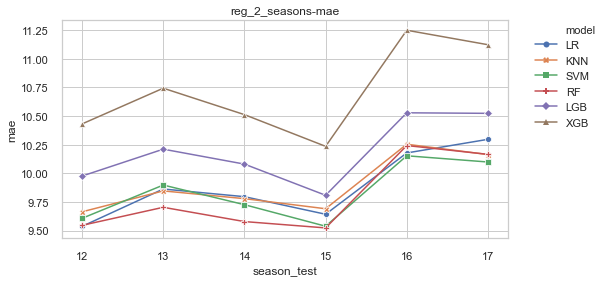

In [31]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [32]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11,2185,12,1209
1,11-12,2181,13,1213
2,12-13,2422,14,1213
3,13-14,2426,15,1213
4,14-15,2426,16,1214
5,15-16,2427,17,1214


### Experiment: train: 3s; test: 1s

In [33]:
experiment_name = f"{exp_prefix}3_seasons"

In [34]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3_seasons
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
15,reg_3_seasons,RF,9.809598,0.314380,12.440092,0.411442
14,reg_3_seasons,SVM,9.824550,0.249880,12.479287,0.351153
12,reg_3_seasons,LR,9.831022,0.231023,12.487218,0.324883
13,reg_3_seasons,KNN,9.943358,0.245539,12.659153,0.339628
16,reg_3_seasons,LGB,10.190443,0.331594,12.904817,0.373543
17,reg_3_seasons,XGB,10.617477,0.335267,13.478740,0.386240


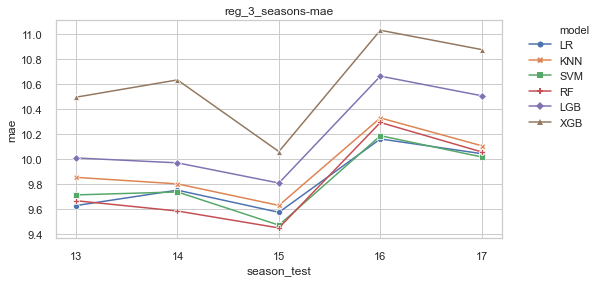

In [35]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [36]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11-12,3394,13,1213
1,11-12-13,3394,14,1213
2,12-13-14,3635,15,1213
3,13-14-15,3639,16,1214
4,14-15-16,3640,17,1214


### Experiment remove last 2q ; train: 2q ; test: 2q

In [37]:
experiment_name = f"{exp_prefix}2q_2q_rl2q"

In [38]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.75, 1.0])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2q_2q_rl2q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
19,reg_2q_2q_rl2q,KNN,10.023826,0.314332,12.674650,0.386685
21,reg_2q_2q_rl2q,RF,10.034111,0.291801,12.680044,0.376266
20,reg_2q_2q_rl2q,SVM,10.363708,0.233560,13.145196,0.377824
22,reg_2q_2q_rl2q,LGB,10.536953,0.343885,13.302349,0.433187
18,reg_2q_2q_rl2q,LR,10.968836,0.322448,13.818984,0.426925
23,reg_2q_2q_rl2q,XGB,11.044959,0.500439,13.854157,0.591536


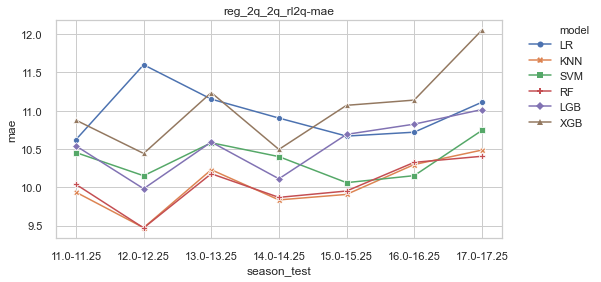

In [39]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [40]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25,606,11.0-11.25,486
1,11.0-11.25,486,12.0-12.25,604
2,12.0-12.25,604,13.0-13.25,606
3,13.0-13.25,606,14.0-14.25,606
4,14.0-14.25,606,15.0-15.25,606
5,15.0-15.25,606,16.0-16.25,607
6,16.0-16.25,607,17.0-17.25,607


### Experiment remove first 2q ;train: 2q ; test: 2q

In [41]:
experiment_name = f"{exp_prefix}2q_2q_rf2q"

In [42]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.25, 0.5])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2q_2q_rf2q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
25,reg_2q_2q_rf2q,KNN,9.825688,0.320442,12.517244,0.346772
27,reg_2q_2q_rf2q,RF,9.847229,0.301536,12.623723,0.343590
28,reg_2q_2q_rf2q,LGB,10.420901,0.297140,13.231462,0.353595
26,reg_2q_2q_rf2q,SVM,10.597010,0.523291,13.445252,0.569299
29,reg_2q_2q_rf2q,XGB,11.116552,0.538354,14.173557,0.625641
24,reg_2q_2q_rf2q,LR,11.437010,0.875705,14.446536,1.149232


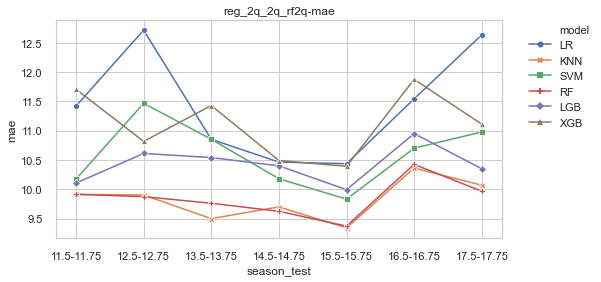

In [43]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [44]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75,607,11.5-11.75,486
1,11.5-11.75,486,12.5-12.75,605
2,12.5-12.75,605,13.5-13.75,607
3,13.5-13.75,607,14.5-14.75,607
4,14.5-14.75,607,15.5-15.75,607
5,15.5-15.75,607,16.5-16.75,607
6,16.5-16.75,607,17.5-17.75,607


### Experiment train: remove last 1q ; 3q ; test: 1q ; step: 3q

In [45]:
experiment_name = f"{exp_prefix}3q_1q_r1q_s3q"

In [46]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, remove_quarters=[1.0], skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q_r1q_s3q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
33,reg_3q_1q_r1q_s3q,RF,9.874930,0.192801,12.487384,0.259262
31,reg_3q_1q_r1q_s3q,KNN,10.040590,0.252768,12.643597,0.356456
32,reg_3q_1q_r1q_s3q,SVM,10.072694,0.366429,12.812899,0.410267
30,reg_3q_1q_r1q_s3q,LR,10.201644,0.189298,12.958156,0.199022
34,reg_3q_1q_r1q_s3q,LGB,10.510101,0.331129,13.269972,0.336092
35,reg_3q_1q_r1q_s3q,XGB,11.056933,0.435036,13.832889,0.543967


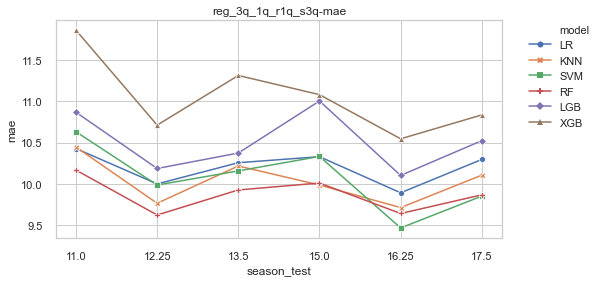

In [47]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [48]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,909,11.0,243
1,11.25-11.5-12.0,788,12.25,302
2,12.5-13.0-13.25,908,13.5,303
3,14.0-14.25-14.5,909,15.0,303
4,15.25-15.5-16.0,909,16.25,304
5,16.5-17.0-17.25,910,17.5,303


### Experiment train: 3q ; test: 1q ; step: 3q

In [49]:
experiment_name = f"{exp_prefix}3q_1q_3s"

In [50]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q_3s
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
39,reg_3q_1q_3s,RF,9.734348,0.406941,12.451689,0.455445
37,reg_3q_1q_3s,KNN,9.774333,0.364695,12.489675,0.433355
40,reg_3q_1q_3s,LGB,10.255482,0.367910,13.122157,0.373339
38,reg_3q_1q_3s,SVM,10.290000,0.506427,13.086640,0.613462
36,reg_3q_1q_3s,LR,10.364829,0.501007,13.250977,0.672293
41,reg_3q_1q_3s,XGB,10.754352,0.385403,13.642352,0.503133


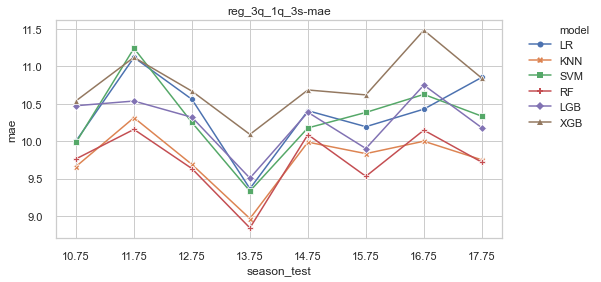

In [51]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [52]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,909,10.75,304
1,11.0-11.25-11.5,729,11.75,243
2,12.0-12.25-12.5,906,12.75,303
3,13.0-13.25-13.5,909,13.75,304
4,14.0-14.25-14.5,909,14.75,304
5,15.0-15.25-15.5,909,15.75,304
6,16.0-16.25-16.5,910,16.75,304
7,17.0-17.25-17.5,910,17.75,304


### Experiment train: 4q ; test: 2q

In [53]:
# experiment_name = f"{exp_prefix}4q_2q"

In [54]:
# del_result_by(experiment_name)

# folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

In [55]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,4))

In [56]:
# utils.folds_to_df(folds, train_seasons, test_seasons)

### Experiment remove first 2q ; train: 4q ; test: 2q

In [57]:
experiment_name = f"{exp_prefix}4q_2q_rf2q"

In [58]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2, remove_quarters=[0.25, 0.50])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_4q_2q_rf2q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
45,reg_4q_2q_rf2q,RF,9.701156,0.427056,12.423401,0.484943
43,reg_4q_2q_rf2q,KNN,9.772899,0.317131,12.542970,0.377145
44,reg_4q_2q_rf2q,SVM,9.914536,0.368497,12.654822,0.435775
42,reg_4q_2q_rf2q,LR,10.088787,0.469919,12.848267,0.559980
46,reg_4q_2q_rf2q,LGB,10.142932,0.477778,12.923587,0.492458
47,reg_4q_2q_rf2q,XGB,10.750917,0.511640,13.744422,0.635511


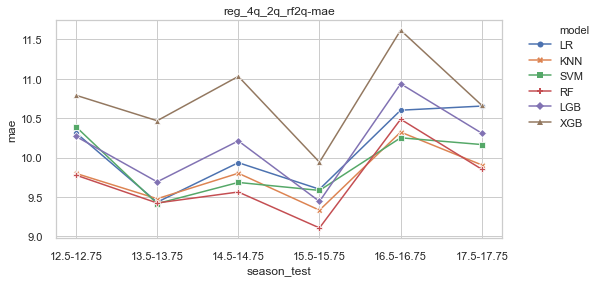

In [59]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [60]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75-11.5-11.75,1093,12.5-12.75,605
1,11.5-11.75-12.5-12.75,1091,13.5-13.75,607
2,12.5-12.75-13.5-13.75,1212,14.5-14.75,607
3,13.5-13.75-14.5-14.75,1214,15.5-15.75,607
4,14.5-14.75-15.5-15.75,1214,16.5-16.75,607
5,15.5-15.75-16.5-16.75,1214,17.5-17.75,607


### Experiments comparison

In [61]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)
utils.serialize_object(f'result_totals_{exp_group_name}', results_total)

In [62]:
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = utils.deserialize_object(exp_group_name, [])
exp_df = get_results_df()

In [63]:
ba_df = exp_df[~exp_df.exp_name.isin(['reg_minmax_data', 'reg_scaled_data'])][['exp_name', 'model',
       'mae_mean', 'mae_std', 'rmse_mean', 'rmse_std']]

In [64]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [65]:
ba_df.sort_values(
    by=["mae_mean"]
    , ascending=True)[:10].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
0,reg_4q_2q_rf2q,RF,9.701156,0.427056,12.423401,0.484943
1,reg_3q_1q_3s,RF,9.734348,0.406941,12.451689,0.455445
2,reg_4q_2q_rf2q,KNN,9.772899,0.317131,12.542970,0.377145
3,reg_3q_1q_3s,KNN,9.774333,0.364695,12.489675,0.433355
4,reg_2_seasons,RF,9.793544,0.296918,12.482894,0.367710
5,reg_3_seasons,RF,9.809598,0.314380,12.440092,0.411442
6,reg_3_seasons,SVM,9.824550,0.249880,12.479287,0.351153
7,reg_2q_2q_rf2q,KNN,9.825688,0.320442,12.517244,0.346772
8,reg_3_seasons,LR,9.831022,0.231023,12.487218,0.324883
9,reg_2_seasons,SVM,9.837152,0.233300,12.530506,0.311140


### Plot experiment results

#### MAE

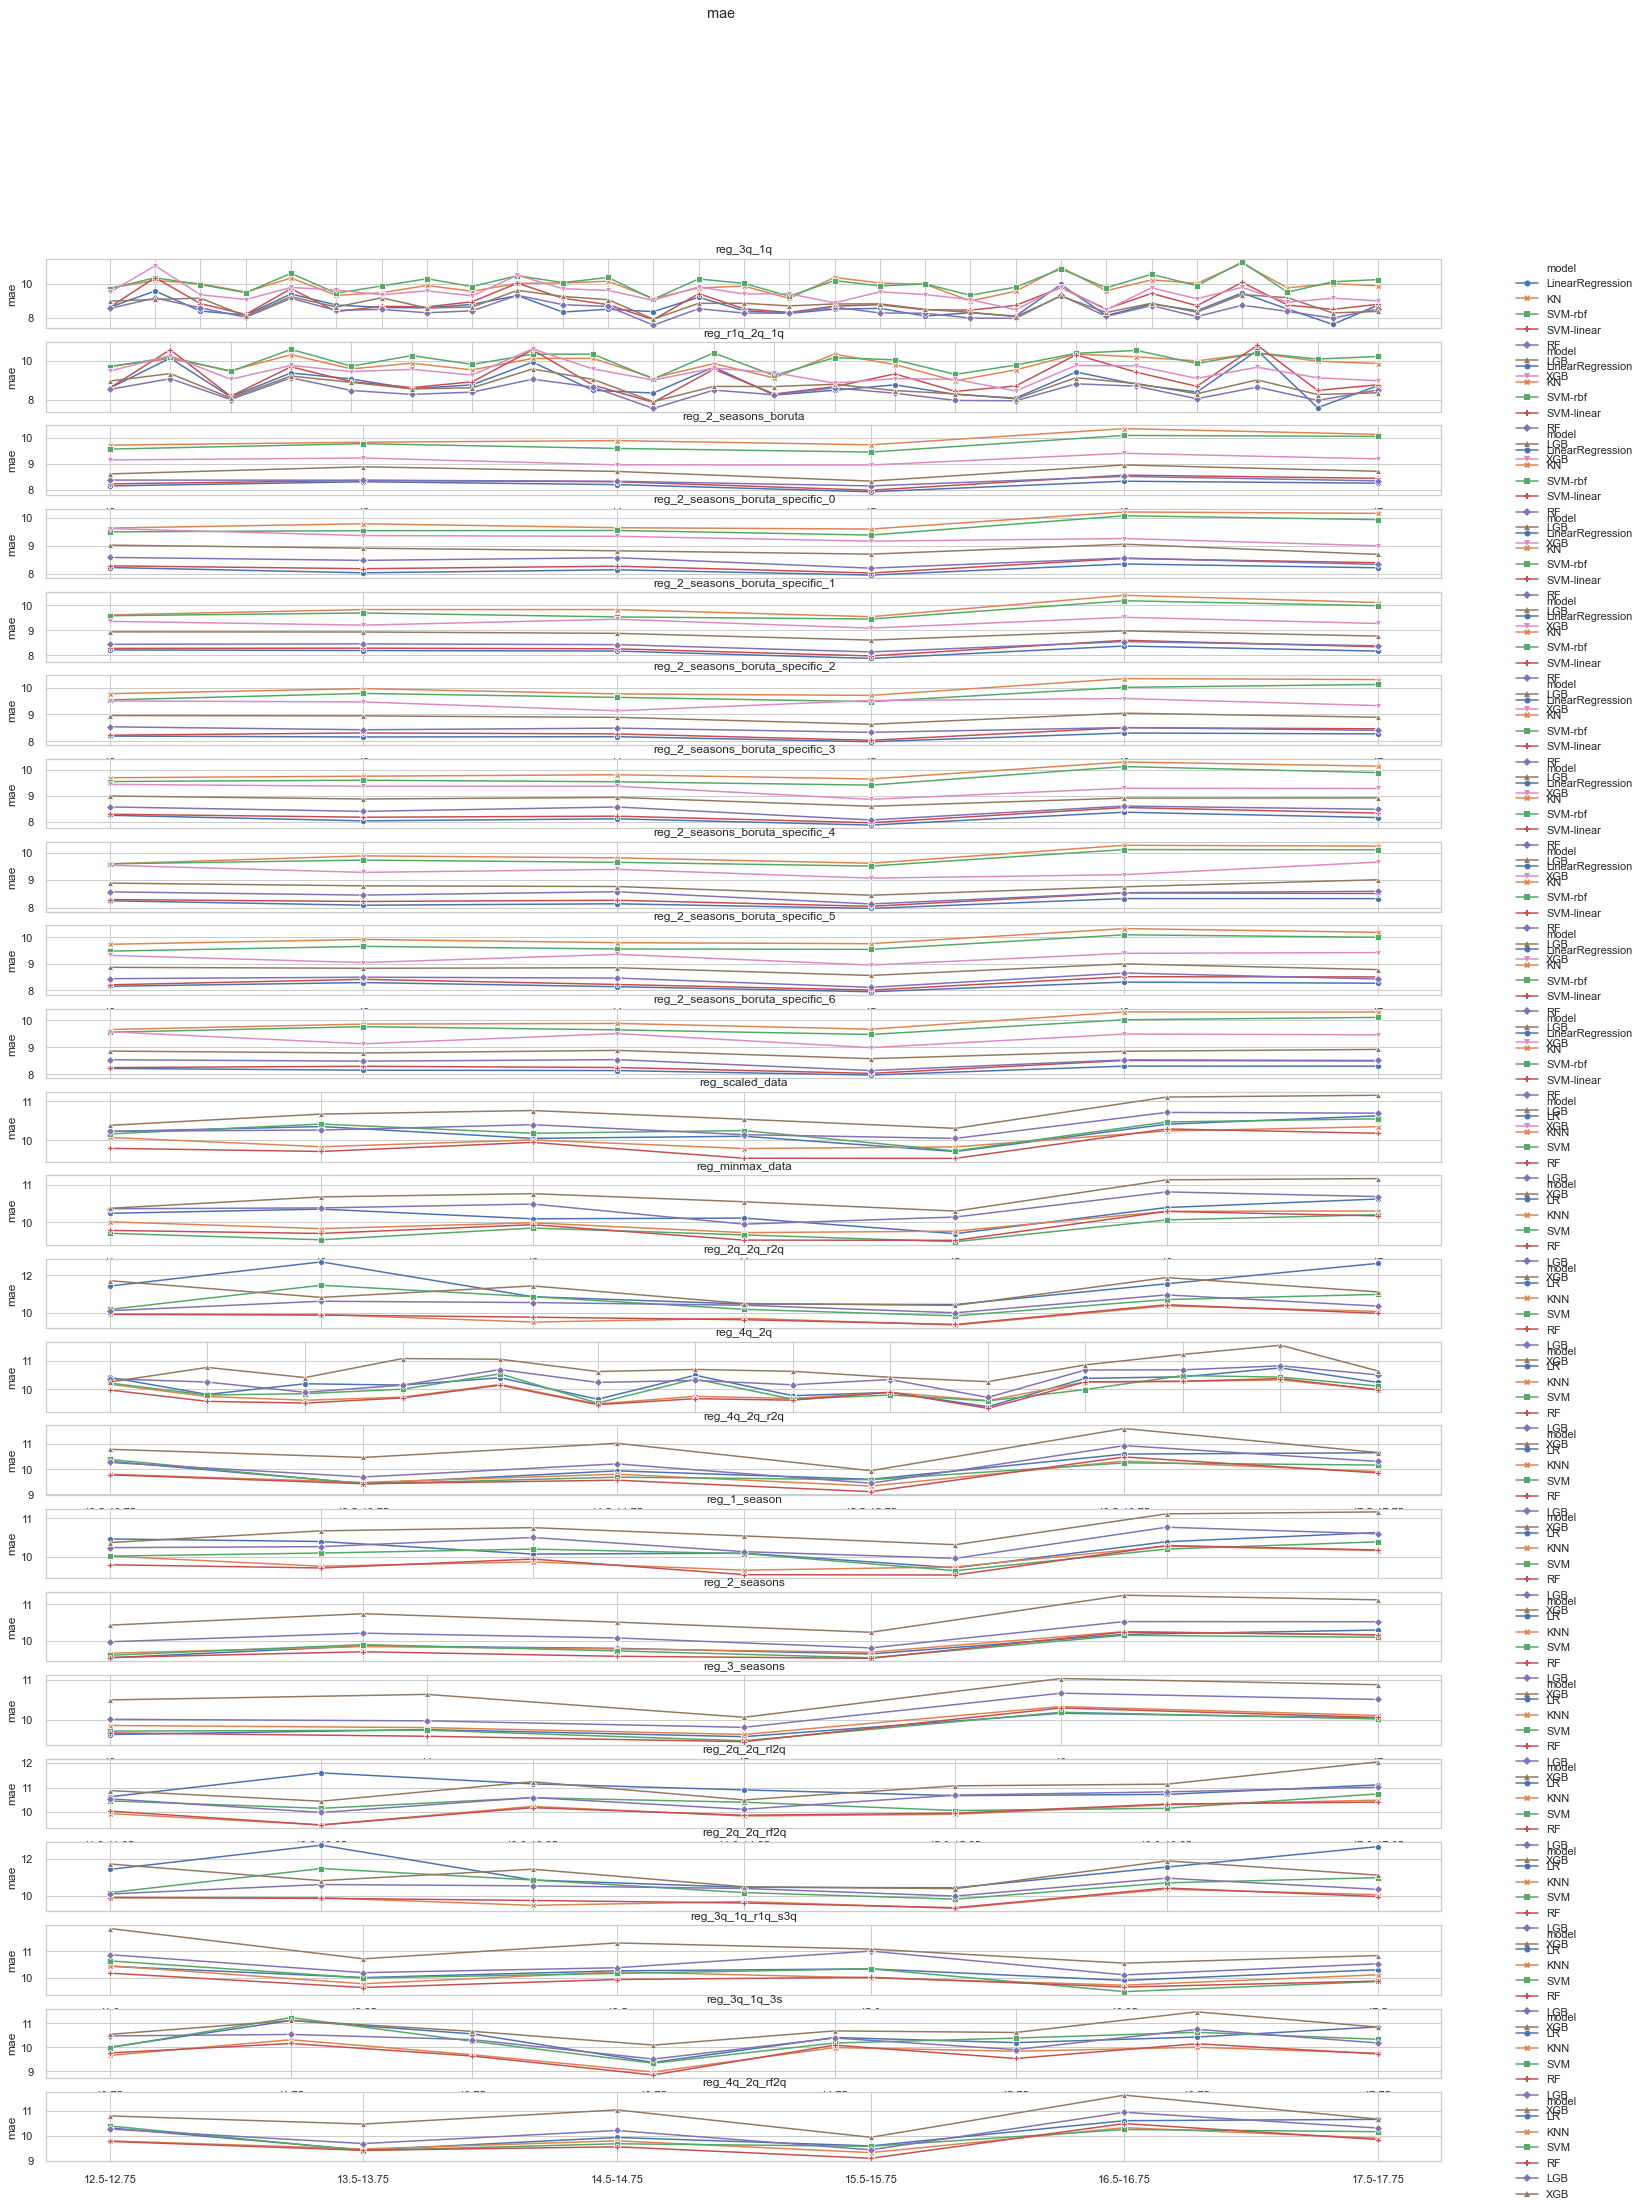

In [66]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mae",
    figsize=(25, 35),
    use_pointplot=True
)

#### MSE

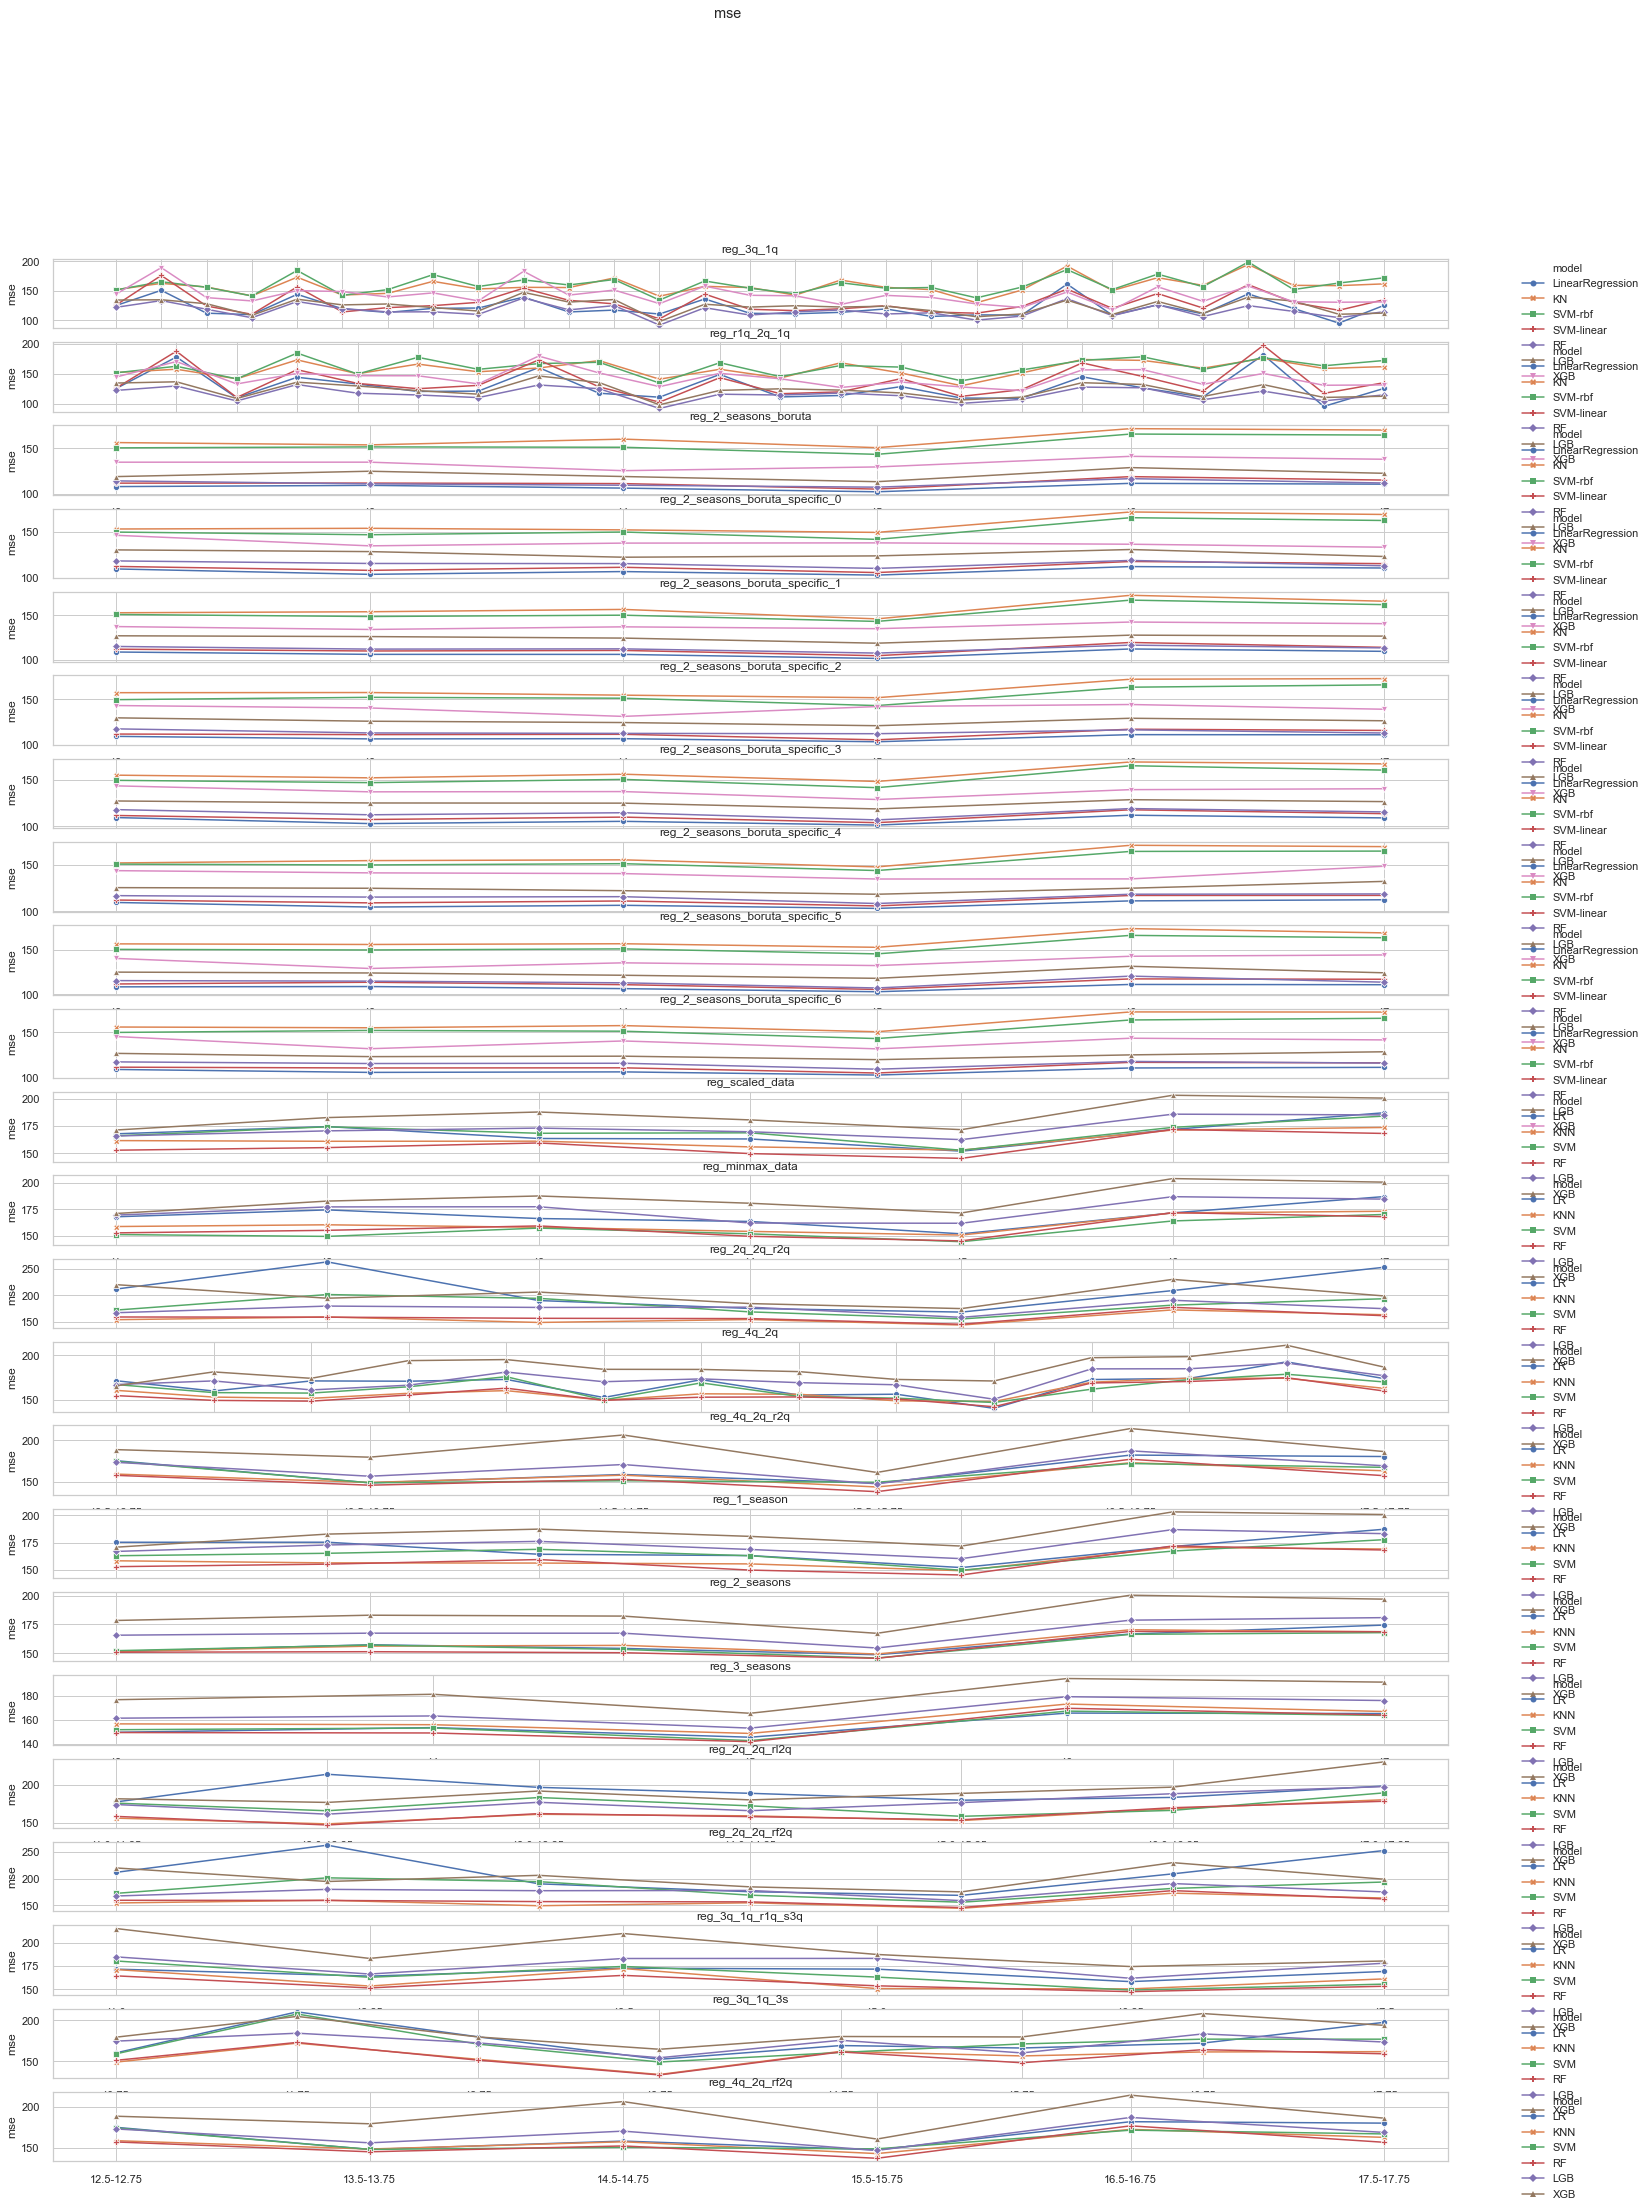

In [67]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mse",
    figsize=(25, 35),
    use_pointplot=True
)

#### RMSE

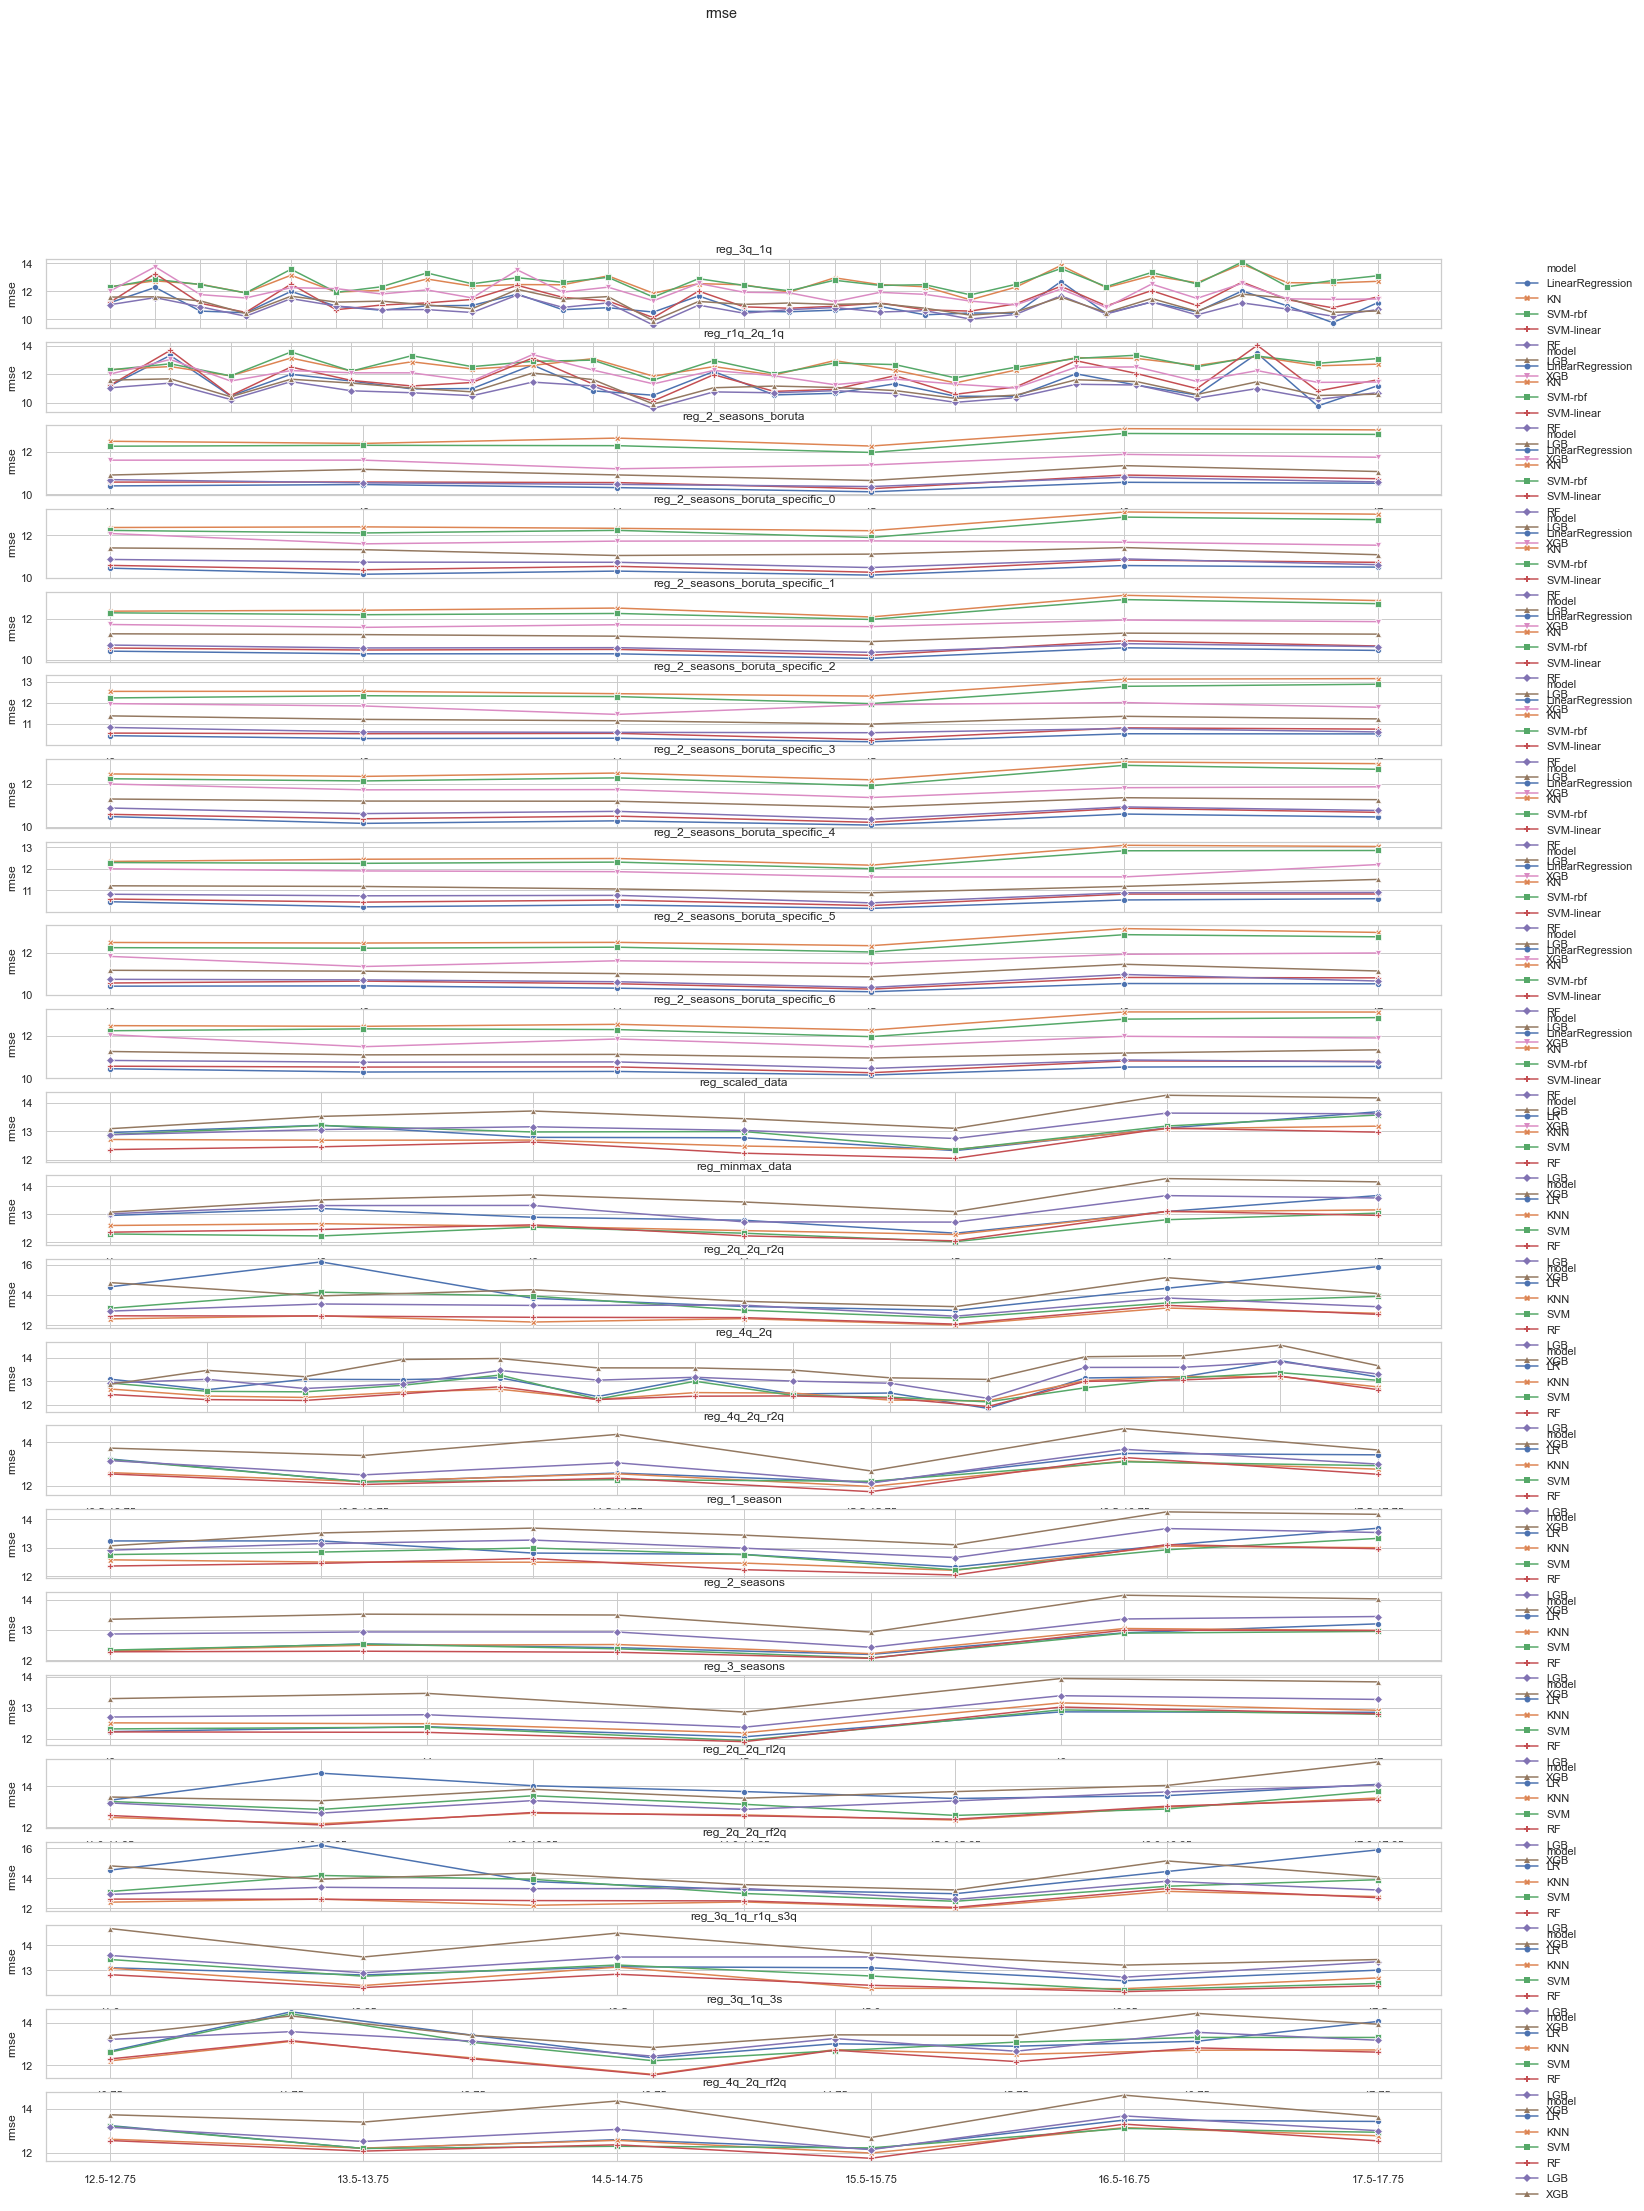

In [68]:
utils.plot_to_compare_experiments(
    results_total,
    metric="rmse",
    figsize=(25, 35),
    use_pointplot=True
)